In [3]:
!source venv/bin/activate

In [2]:
cd ..

/home/roman/python_project/rag_research


In [1]:
ls

data/             __init__.py                 query_rewriting.ipynb
fill_vbase.ipynb  proposition_chunking.ipynb  reranker_rag.ipynb
functions.py      __pycache__/                simple_rag.ipynb
hyde.ipynb        query_decomposition.ipynb


In [4]:
from datasets import load_dataset
from tqdm.notebook import tqdm
from langchain_text_splitters import RecursiveCharacterTextSplitter
import pandas as pd

from research.functions import get_natural_questions_sample, get_ms_marco_sample

# Natural Questions

In [5]:
natural_questions = load_dataset("natural_questions", split="validation[:1000]")

Resolving data files:   0%|          | 0/287 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/287 [00:00<?, ?it/s]

In [13]:
question, context, answer = get_natural_questions_sample(natural_questions[2])

# Вносим данные в векторное хранилище

In [7]:
from database.vbase import QdrantBase

/home/roman/jupyter/lib/python3.12/site-packages/awq/__init__.py:21: DeprecationWarning: 
I have left this message as the final dev message to help you transition.

Important Notice:
- AutoAWQ is officially deprecated and will no longer be maintained.
- The last tested configuration used Torch 2.6.0 and Transformers 4.51.3.
- If future versions of Transformers break AutoAWQ compatibility, please report the issue to the Transformers project.

Alternative:
- AutoAWQ has been adopted by the vLLM Project: https://github.com/vllm-project/llm-compressor

For further inquiries, feel free to reach out:
- X: https://x.com/casper_hansen_
- LinkedIn: https://www.linkedin.com/in/casper-hansen-804005170/

  warnings.warn(_FINAL_DEV_MESSAGE, category=DeprecationWarning, stacklevel=1)


In [15]:
base = QdrantBase(
    model_name='BAAI/bge-m3',
    vector_dimension=1024,
    collection_name='natural_questions',
    device='cuda',
)

In [9]:
dataset = {
    'question': [],
    'answer': [],
}
texts = []

null_count = 0
max_null = 100

for data in tqdm(natural_questions):
    if len(texts) == 500:
        break
    
    question, context, answer = get_natural_questions_sample(data)
    if answer == '' and null_count < max_null:
        null_count += 1
        texts.append(context)
        dataset['question'].append(question)
        dataset['answer'].append(answer)
        continue
    elif answer != '':
        texts.append(context)
        dataset['question'].append(question)
        dataset['answer'].append(answer)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
df = pd.DataFrame(dataset)
df.to_csv('research/qa_dataset.csv', index=False)

In [13]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=600,
    chunk_overlap=50,
    length_function=len,
    separators=["\n\n", "\n", ".", " ", ""]
)

In [16]:
id_ = 0
for text in tqdm(texts):
    chunks = text_splitter.split_text(text)
    for chunk in chunks:
        base.add_point([chunk], {'id': id_})
        id_ += 1

  0%|          | 0/500 [00:00<?, ?it/s]

# EDA

In [71]:
from qdrant_client import QdrantClient
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
def get_info(collection_name, limit=5000):
    collection_info = client.get_collection(collection_name)
    print(f"Коллекция {collection_name}: {collection_info.points_count} точек")

    print(f'Анализируется {limit} точек')
    points = client.scroll(
        collection_name=collection_name,
        limit=limit,
        with_payload=True,
        with_vectors=True
    )[0]
    
    embeddings = []
    ids = []
    
    for point in points:
        embeddings.append(point.vector)
        ids.append(str(point.id))
        
    embeddings = np.array(embeddings)

    # DBSCAN кластеризация
    dbscan = DBSCAN(eps=0.3, min_samples=5)
    dbscan_labels = dbscan.fit_predict(embeddings)
    
    # Метрики
    clustering_metrics = {
        'silhouette_dbscan': silhouette_score(embeddings, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1,
        'calinski_harabasz_dbscan': calinski_harabasz_score(embeddings, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1,
        'n_clusters_dbscan': len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0),
        'noise_points_dbscan': list(dbscan_labels).count(-1),
        'dbscan_labels': dbscan_labels
    }
    cosine_sim = cosine_similarity(embeddings)
        
    # Евклидовы расстояния
    euclidean_dist = euclidean_distances(embeddings)
    
    # Убираем диагональ (расстояние точки до самой себя)
    np.fill_diagonal(cosine_sim, 0)
    np.fill_diagonal(euclidean_dist, 0)
    
    distance_metrics = {
        'cosine_similarity_mean': np.mean(cosine_sim[cosine_sim > 0]),
        'cosine_similarity_std': np.std(cosine_sim[cosine_sim > 0]),
        'euclidean_distance_mean': np.mean(euclidean_dist[euclidean_dist > 0]),
        'euclidean_distance_std': np.std(euclidean_dist[euclidean_dist > 0]),
        'cosine_similarity_matrix': cosine_sim,
        'euclidean_distance_matrix': euclidean_dist
    }

    print("Метрики кластеризации:")
    print(f"Silhouette Score (DBSCAN): {clustering_metrics['silhouette_dbscan']:.3f}")
    print(f"Calinski-Harabasz Score (DBSCAN): {clustering_metrics['calinski_harabasz_dbscan']:.3f}")
    print(f"Количество кластеров (DBSCAN): {clustering_metrics['n_clusters_dbscan']}")
    print(f"Шумовые точки (DBSCAN): {clustering_metrics['noise_points_dbscan']}")
    
    print("Метрики расстояний:")
    print(f"Среднее косинусное сходство: {distance_metrics['cosine_similarity_mean']:.3f}")
    print(f"Стандартное отклонение косинусного сходства: {distance_metrics['cosine_similarity_std']:.3f}")
    print(f"Среднее евклидово расстояние: {distance_metrics['euclidean_distance_mean']:.3f}")
    print(f"Стандартное отклонение евклидова расстояния: {distance_metrics['euclidean_distance_std']:.3f}")
    
    # Распределение расстояний
    plot_distance_distribution(distance_metrics, collection_name)


In [94]:
def plot_distance_distribution(distance_metrics: Dict, title: str):
        """
        Строит распределение расстояний
        
        Args:
            distance_metrics: метрики расстояний
            title: заголовок
        """
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Косинусное сходство
        cosine_sim = distance_metrics['cosine_similarity_matrix']
        cosine_values = cosine_sim[cosine_sim > 0]
        
        axes[0].hist(cosine_values, bins=50, alpha=0.7, edgecolor='black')
        axes[0].set_title(f'Распределение косинусного сходства {title}')
        axes[0].set_xlabel('Косинусное сходство')
        axes[0].set_ylabel('Частота')
        axes[0].axvline(np.mean(cosine_values), color='red', linestyle='--', 
                       label=f'Среднее: {np.mean(cosine_values):.3f}')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Евклидово расстояние
        euclidean_dist = distance_metrics['euclidean_distance_matrix']
        euclidean_values = euclidean_dist[euclidean_dist > 0]
        
        axes[1].hist(euclidean_values, bins=50, alpha=0.7, edgecolor='black')
        axes[1].set_title(f'Распределение евклидова расстояния {title}')
        axes[1].set_xlabel('Евклидово расстояние')
        axes[1].set_ylabel('Частота')
        axes[1].axvline(np.mean(euclidean_values), color='red', linestyle='--', 
                       label=f'Среднее: {np.mean(euclidean_values):.3f}')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

In [95]:
client = QdrantClient(host='localhost', port=6333)

Коллекция natural_questions: 39919 точек
Анализируется 5000 точек
Метрики кластеризации:
Silhouette Score (DBSCAN): -0.019
Calinski-Harabasz Score (DBSCAN): 14.331
Количество кластеров (DBSCAN): 5
Шумовые точки (DBSCAN): 4924
Метрики расстояний:
Среднее косинусное сходство: 0.344
Стандартное отклонение косинусного сходства: 0.070
Среднее евклидово расстояние: 1.144
Стандартное отклонение евклидова расстояния: 0.064


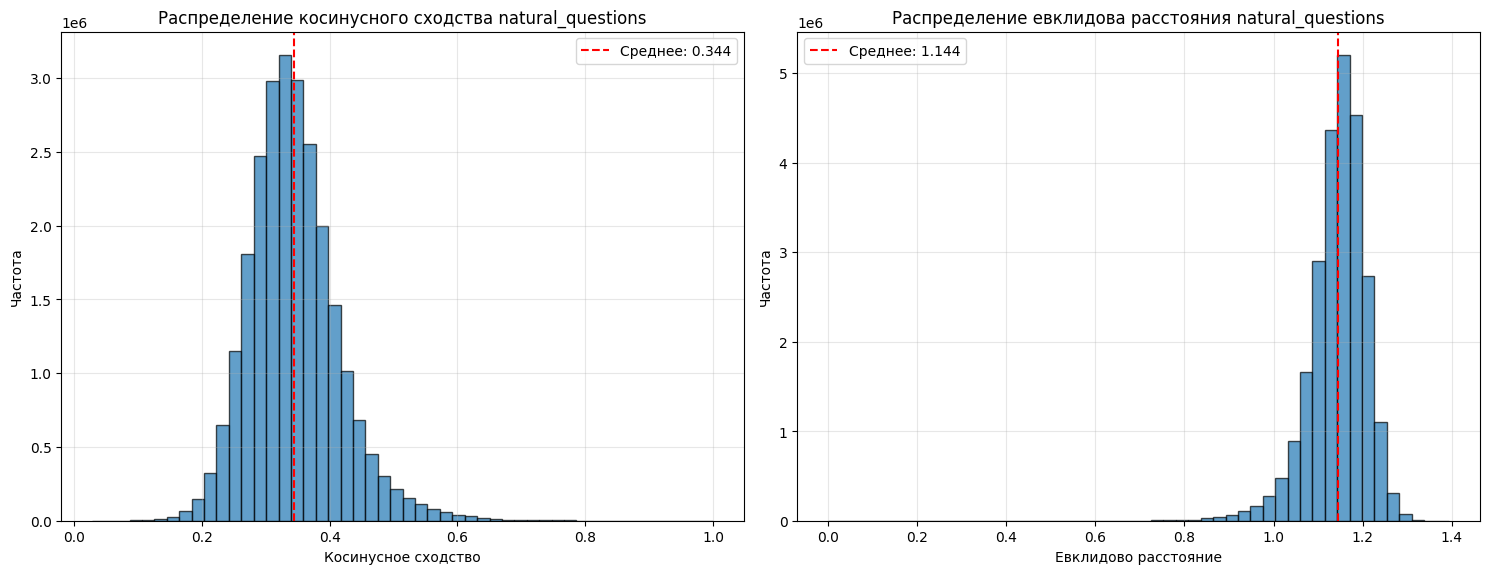

In [96]:
get_info('natural_questions')